# Data project
In this project we investigate statistics from all FIFA World Cup tournaments from 1930-2014. The main question we want to answer is: "Who has been the all time most succesfull coach in the world cup?". We answer this question by calculating the win-ratio of all coaches as the share of wins out of the total number of games played at World Cups. Furthermore, we describe the performances of some of the most succesfull teams in the World Cup. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
#from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

The data used in this assignment is downloaded from www.kaggle.com, but it originates from the FIFA website. We use data from three different CSV-files, which are imported as dataframes below. 

In [2]:
worldcups = pd.read_csv('WorldCups.csv')
matches = pd.read_csv('WorldCupMatches.csv')
players = pd.read_csv('WorldCupPlayers.csv')

We want different informations from the different dataframes. The coach names are extracted from the dataset WorldCupPlayers. The dataset includes one row for every player for every game at World Cup tournaments from 1930 to 2014, but we only need the coach names for every match. Therefore, we drop the duplicate rows, ending up with a DataFrame containing the names of the two coaches for every MatchID. 

In [3]:
coaches = players[['MatchID', 'Coach Name']]
coaches = coaches.drop_duplicates()
coaches.head()

,MatchID,Coach Name
0,1096,CAUDRON Raoul (FRA)
1,1096,LUQUE Juan (MEX)
33,1090,MILLAR Bob (USA)
34,1090,GOETINCK Hector (BEL)
65,1093,SIMONOVIC Bosko (YUG)


Since the dataset only includes the scores, and not explicity the winner of each game, we define a function that evaluates a winning team based on the scores and apply this to a new column in our matches dataframe. Thus, we only consider the score after normal and extended game-time, meaning that potential penalty shoot-outs are not taken into account. 

In [4]:
def winning_team(X): 
    ### Function returns the initials of the team, who scored the most goals. In case of a tie: 'draw'. 
    if X['Home Team Goals'] > X['Away Team Goals']:
        return X['Home Team Initials']
    if X['Home Team Goals'] < X['Away Team Goals']:
        return X['Away Team Initials'] 
    else:
        return 'draw'

matches['winning_team'] = matches.apply(winning_team,axis=1)

We now merge the two dataframes on the "MatchID" to get the coach name and all the match information in one dataframe

In [5]:
merged = pd.merge(matches, coaches, how = 'left', on = ['MatchID'] )

To be able to work with data for the coaches' names as well as their countries, we split up the Coach Name column into to separate columns; Coach Name and Coach Team. 

In [6]:
merged['Coach Team'] = merged['Coach Name'].str[-4:-1]
merged['Coach Name'] = merged['Coach Name'].str[:-6]

In order to analyse the coaches' success during World Cups, we calculate the winning ratio of each coach as the share of games won out of played games. 

In [20]:
#Firstly we count the number of games per coach
games_coach = merged.groupby(['Coach Name']).agg(['count'])
games_coach = games_coach['Year']
games_coach.rename(columns={'count':'Matches played'}, inplace=True)

#We then find the number of wins per coach
wins_coach = merged.loc[merged['Coach Team'] == merged['winning_team']].groupby(['Coach Name']).agg(['count'])
wins_coach = wins_coach['Year']
wins_coach.rename(columns={'count':'Matches won'}, inplace=True)

#We then combine the two dataframes and caculate the winratio
coach_stats = pd.merge(games_coach, wins_coach, how = 'left', on = 'Coach Name')
coach_stats = coach_stats.fillna(0)

coach_stats['winning_ratio'] = coach_stats['Matches won'] / coach_stats['Matches played'] * 100 
coach_stats = coach_stats.sort_values(by = ['winning_ratio'], ascending = False)

coach_stats.head(10)

,Matches played,Matches won,winning_ratio
Coach Name,,,
SUPPICI Alberto,4,4.0,100.000000
POZZO Vittorio,9,8.0,88.888889
Bert VAN MARWIJK,7,6.0,85.714286
JACQUET Aime,7,6.0,85.714286
VICINI Azeglio,7,6.0,85.714286
GORSKI Kazimierz,7,6.0,85.714286
MOREIRA Aymore,6,5.0,83.333333
LOEW Joachim,18,15.0,83.333333
MARADONA Diego,5,4.0,80.000000


In [24]:
coach_stats.describe()

,Matches played,Matches won,winning_ratio
count,334.000000,334.000000,334.000000
mean,5.101796,1.583832,24.404831
std,3.825212,2.393154,26.171198
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,4.000000,1.000000,25.000000
75%,6.000000,2.000000,40.000000
max,25.000000,16.000000,100.000000


The average winning ratio for coaches in the World Cup is just under 25%, and 334 coaches have been in the world cup from 1930 to 2014. This number is being dragged down by a lot of coaches who only played one or two matches, and never won any, which also appears from the 25 percentile of 0% winning ratios. We see as well from the table above that some of the coaches with the highest winning ratios have only played very few games. To examine more deeply the coaches who played a few more games, we create the dataframes below for coaches who have played more than 10 and 15 games, respectively.

In [27]:
min10 = coach_stats.loc[coach_stats['Matches played'] >= 10]
min15 = coach_stats.loc[coach_stats['Matches played'] >= 15]
min10.head()

,Matches played,Matches won,winning_ratio
Coach Name,,,
LOEW Joachim,18,15.0,83.333333
SANTANA Tele,10,8.0,80.000000
DEL BOSQUE Vicente,10,7.0,70.000000
RAMSEY Alf,10,7.0,70.000000
ZAGALLO Mario,20,13.0,65.000000


In [15]:
min15.head()

,Matches played,Matches won,winning_ratio
Coach Name,,,
LOEW Joachim,18,15.0,83.333333
ZAGALLO Mario,20,13.0,65.000000
SCHOEN Helmut,25,16.0,64.000000
BEARZOT Enzo,18,9.0,50.000000
HERBERGER Sepp,18,9.0,50.000000


In [43]:
avg10 = min10['winning_ratio'].mean()
coaches10 = min10['winning_ratio'].count()

print(f'Average winning ratio for number of games > 10: {avg10:6.2f} %')
print(f'{coaches10:6.0f} coaches played more than 10 games in the world cup')

Average winning ratio for number of games > 10:  41.58 %
    33 coaches played more than 10 games in the world cup


We see from the statistics above, that the winning ratios are markably higher when coaches with only a few games are excluded, and the field is also heavily narrowing down to only 33 coaches who have played more than 10 games. The average winning ratios are now above 40%. The German coach, Joachim Loew is on top on both tables considering coaches with minimum 10 and 15 games played, with an impressive record of 15 wins in 18 games, yielding a winning ratio of 83.3%. 

$$\textbf{Thus, according to our analysis, Joachim Loew is the all time most successfull World Cup coach.} $$

![Most successfull coach](Loew.jpg "Joachim Loew")

# Countries
To obtain deeper knowledge about some of the countries and their coaches, 3 countries are chosen in this part of the assignment. Spain, the Netherlands and Germany are chosen, since they are all famous in international football and they all have coaches in top of the different conditioned dataframes from above - Del Bosque, Van Gaal and Loew. 

First we create a new dataframe which only includes the relevant information.

In [57]:
Coachdf = merged[['Year','MatchID','Home Team Initials','Home Team Goals'
                 ,'Away Team Goals','Away Team Initials','winning_team','Coach Name','Coach Team']]

We then create 5 series that count the number of occurrences which is used for further investigation. One that counts the number of games for each coach, one that counts the number of games for each country, one that count the number wins for each county per year. 

In [58]:
#The first counts the number of games for each coach
NumberCoach=Coachdf.groupby(['Coach Team','Coach Name'])['winning_team'].count()

#The second counts the number of games for each country
NumberMatches=Coachdf.groupby(['winning_team'])['winning_team'].count()

#We then create a new dataset that only includes the winnerteam per game.
I = Coachdf['winning_team'] != Coachdf['Coach Team']
Coachdf.drop(Coachdf[I].index, inplace=True)

#The Third Series counts the number wins for each county per year, 
NumberWinsYear=Coachdf.groupby(['winning_team','Year'])['winning_team'].count() 

#The fouth counts the number of wins for each coach. 
NumberWinsCoach=Coachdf.groupby(['winning_team','Coach Name'])['winning_team'].count()  

#The fifth counts the number of wins for each country.  
NumberWins=Coachdf.groupby(['winning_team'])['winning_team'].count() 

In [59]:
Years = Coachdf['Year'].drop_duplicates()
Year_df=pd.Series.to_frame(Years)
GER=pd.Series.to_frame(NumberWinsYear['GER'])
GER.rename(columns={'winning_team':'GER'}, inplace=True)

ESP=pd.Series.to_frame(NumberWinsYear['ESP'])
ESP.rename(columns={'winning_team':'ESP'}, inplace=True)

NED=pd.Series.to_frame(NumberWinsYear['NED'])
NED.rename(columns={'winning_team':'NED'}, inplace=True)

# Merging all to one dataset
Plot_data = pd.merge(Year_df, GER,how='left',on='Year')
Plot_data = pd.merge(Plot_data, ESP,how='left',on='Year')
Plot_data = pd.merge(Plot_data, NED,how='left',on='Year')

In [50]:
def _plot_timeseries(dataframe, variable):
    
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax1 = fig.add_subplot(1,1,1)
    
    x = dataframe['Year']
    y = dataframe[variable]
    
    ax.bar(x,y)
    ax.set_xlabel('Year of World Cup')
    ax.set_ylabel('Number of matches won')
    ax.set_title('Number of matches won (' + str(variable) + ')')
    ax.yaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
    
def plot_timeseries(dataframe):
    
    widgets.interact(_plot_timeseries, 
    dataframe = widgets.fixed(dataframe),
    variable = widgets.Dropdown(
        description='Country', 
        options=['GER','ESP','NED'], 
        value='GER')                 
); 

In [55]:
plot_timeseries(Plot_data)

interactive(children=(Dropdown(description='Country', options=('GER', 'ESP', 'NED'), value='GER'), Output()), …

The interactive plot above shows the number of matches won for each World Cup for each of the three countries. Navigating to the Germany plot, we clearly see Loew's World Cup victory with Germany in 2014. We also see that even though Spain won the 2010 world cup and the Netherlands got a second place, they actually won the same number of games that year. It is also worth noticing that Spain has qualified for every World Cup since 1986. 

Note: From the 1940's to the 1990's, Germany was split up, which explains the missing data in this period. West Germany is included in the dataset as Germany FR. 

We transform all series into dataframes in order to construct a venn diagram for each of the coaches. 

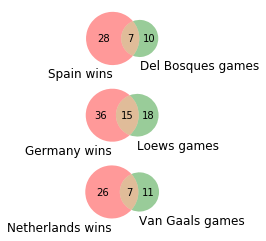

In [60]:
#Convert the series to dataframe
NumberWinsCoach_DF=pd.Series.to_frame(NumberWinsCoach)
NumberWins_DF=pd.Series.to_frame(NumberWins)
NumberCoach_DF=pd.Series.to_frame(NumberCoach)
NumberMatches_DF=pd.Series.to_frame(NumberMatches)

#We then rename the column winning._team, into what it actually shows. 
NumberWinsCoach_DF.rename(columns={'winning_team':'NumberWins'},inplace=True)
NumberWins_DF.rename(columns={'winning_team':'NumberWins'},inplace=True)
NumberCoach_DF.rename(columns={'winning_team':'NumberMatches'},inplace=True)

#Creating Venn diagram for Spain
plt.subplot(3,1, 1)
venn2(subsets = (NumberWins_DF.at['ESP','NumberWins']
                ,NumberCoach_DF.at[('ESP','DEL BOSQUE Vicente'),"NumberMatches"] 
                ,NumberWinsCoach_DF.at[('ESP','DEL BOSQUE Vicente'),"NumberWins"])
      ,set_labels = ('Spain wins', 'Del Bosques games'))

#Creating Venn diagram for Germany
plt.subplot(3,1, 2)
venn2(subsets = (NumberWins_DF.at['GER','NumberWins']
                ,NumberCoach_DF.at[('GER','LOEW Joachim'),"NumberMatches"] 
                ,NumberWinsCoach_DF.at[('GER','LOEW Joachim'),"NumberWins"])
      ,set_labels = ('Germany wins', 'Loews games'))

#Creating Venn diagram for Netherlands
plt.subplot(3,1,3)
venn2(subsets = (NumberWins_DF.at['NED','NumberWins']
                ,NumberCoach_DF.at[('NED','Louis VAN GAAL'),"NumberMatches"] 
                ,NumberWinsCoach_DF.at[('NED','Louis VAN GAAL'),"NumberWins"])
      ,set_labels = ('Netherlands wins', 'Van Gaal''s games'))

plt.show()

The diagrams above show the number of games coached by each of the three coaches and the total number of wins by each of the nations. The diagrams show that out of Germanys 36 World Cup game wins, Loew has lead the team to almost half. Del Bosque and Van Gaal both led their teams to about a third of the nation's total World Cup wins. 